# 📝 IBM HR 분석: 직원 이직 및 성과 
### (IBM HR Analytics Employee Attrition & Performance)

- ⭐목표: 직원 이직 여부를 예측하는 모델을 구축하고, 직원의 이직 원인과 관련된 인사이트를 도출<br>
- ⭐예상 결과: 모델을 통해 향후 이직할 가능성이 있는 직원을 예측하고 조직의 인사 전략 대응 및 개선 방향
    - 가설: 
    1) MonthlyIncome 이 낮을수록 이직률이 낮을 가능성 
    2) JobSatisfaction 가 클수록 이직 낮을 가능성 
    3) OverTime 이 No 일때 이질률 늦을 가능성
    4) DistanceFromHome 가 적을수록
- ⭐아키텍처 정의: 데이터 수집, 데이터 처리, 데이터분석, 시각화, 머신러닝 모델링생성 및 평가
- ⭐개발 및 환경 구축: 
     - PySpark 의한 데이터 처리
     - Python 데이터 분석 및 머신모델을 위한 언어
     - Pandas
     - Jupyter Notebook 코드 실행 및 결과 확인을 위한 인터페이스
     - AWS EC2 클라우드 환경 사용
     - GitHub: 코드 백업

- ⭐계발 계획
    1. 데이터수집
    2. 데이터 전처리
    3. 탐색적 데이터 분석 (EDA) 
    4. 머신러닝 모델링
        - 모델링 접근: 종속변수(Attrition, YES or NO)가 이진(binary) 형태여서 Logistic Regression 분석
        - 이직 여부와 각 독립 변수 간의 관계를 파악
    5. 모델 평가
        - 테스트 계획: 훈련 데이터와 테스트 데이터를 나누어 모델 성능 테스트 
    6. 저장
- ⭐데이터 출처: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset/data


# 1. 데이터수집

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Employee_Attrition").getOrCreate()
spark

24/12/19 18:06:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
df = spark.read.format("csv")\
    .option("header",'true')\
    .option('inferSchema', 'true')\
    .load("data/HR-Employee-Attrition.csv")

In [3]:
#필요한 라이브러리 불러오기 

from pyspark.sql.functions import *
from pyspark.ml import *
from pyspark.ml.feature import *
from pyspark.ml.recommendation import *
from pyspark.ml.evaluation import *
from pyspark.ml.classification import *
from pyspark.sql.types import *
from pyspark.ml.stat import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 데이터 구조 확인

In [4]:
df.count()

1470

In [5]:
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- EmployeeNumber: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- OverTime: string 

## 컬럼 설명

- Age: 직원의 나이
- Attrition: 직원의 이직 여부 (Yes or No)
- BusinessTravel: 직원의 출장 빈도 (Non-Travel, Travel_Rarely, Travel_Frequently)
- DailyRate: 직원의 일일 급여
- Department: 직원이 속한 부서 (Research & Development, Sales, Human Resources)
- DistanceFromHome: 직원의 집으로부터 회사까지의 거리
- Education: 직원의 학력 수준 (1: Below College, 2: College, 3: Bachelor, 4: Master, 5: Doctor)
- EducationField: 직원의 전공 분야
- EmployeeCount: 직원 수 (모든 값이 1로 동일)
- EmployeeNumber: 직원의 고유 번호
- EnvironmentSatisfaction: 직원의 업무 환경 만족도 (1: Low, 2: Medium, 3: High, 4: Very High)
- Gender: 직원의 성별 (Male, Female)
- HourlyRate: 직원의 시간당 급여
- JobInvolvement: 직원의 직무 참여도 (1: Low, 2: Medium, 3: High, 4: Very High)
- JobLevel: 직원의 직급
- JobRole: 직원의 직무
- JobSatisfaction: 직원의 직무 만족도 (1: Low, 2: Medium, 3: High, 4: Very High)
- MaritalStatus: 직원의 결혼 여부 (Single, Married, Divorced)
- MonthlyIncome: 직원의 월급
- MonthlyRate: 직원의 월별 급여 총액
- NumCompaniesWorked: 직원이 근무한 회사 수
- Over18: 직원이 18세 이상인지 여부 (모든 값이 Y로 동일)
- OverTime: 직원의 초과 근무 여부 (Yes, No)
- PercentSalaryHike: 직원의 급여 인상 비율
- PerformanceRating: 직원의 성과 평가 등급 (1: Low, 2: Good, 3: Excellent, 4: Outstanding)
- RelationshipSatisfaction: 직원의 동료와의 관계 만족도 (1: Low, 2: Medium, 3: High, 4: Very High)
- StandardHours: 직원의 표준 근무 시간 (모든 값이 80으로 동일)
- StockOptionLevel: 직원의 주식 옵션 수준 (0, 1, 2, 3)
- TotalWorkingYears: 직원의 총 근무 연수
- TrainingTimesLastYear: 지난해 직원이 받은 교육 횟수
- WorkLifeBalance: 직원의 일-생활 균형 만족도 (1: Bad, 2: Good, 3: Better, 4: Best)
- YearsAtCompany: 직원이 현재 회사에서 근무한 기간
- YearsInCurrentRole: 직원이 현재 역할에서 근무한 기간
- YearsSinceLastPromotion: 직원의 마지막 승진 이후 경과된 기간
- YearsWithCurrManager: 직원이 현재 관리자와 함께 일한 기간

In [6]:
df.show(3)

24/12/19 18:02:01 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+---------+-----------------+---------+--------------------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|   BusinessTravel|DailyRate|          Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalanc

# 2. 데이터 전처리

In [7]:
#각 컬럼별 null 값 개수 확인

null_counts = df.select(
    [
    sum(when(col(c).isNull() | isnan(c),1).otherwise(0)).alias(c) for c in df.columns
    ]
)

null_counts.show()

+---+---------+--------------+---------+----------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+-------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|BusinessTravel|DailyRate|Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSinceLastPr

In [8]:
# 중복 데이터 확인 (중복 행의 개수 확인)
df.groupBy(df.columns).count().filter(col("count") > 1).show()

+---+---------+--------------+---------+----------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+-------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+-----+
|Age|Attrition|BusinessTravel|DailyRate|Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSince

# 불필요한 컬럼 제거 

- EmployeeNumber 직원 고유번호라 불필요하다고 추정
- EmployeeCount, Over18, StandardHours MonthlyRate : 단일 값만 가짐
- DailyRate, HourlyRate, MonthlyRate : MonthlyIncome을 사용할 수 있어서 불필요 


In [4]:
df = df.drop("EmployeeNumber","EmployeeCount", "Over18", "StandardHours", "DailyRate", "HourlyRate", "MonthlyRate")
df.show(5)

24/12/19 18:06:51 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+---------+-----------------+--------------------+----------------+---------+--------------+-----------------------+------+--------------+--------+--------------------+---------------+-------------+-------------+------------------+--------+-----------------+-----------------+------------------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|   BusinessTravel|          Department|DistanceFromHome|Education|EducationField|EnvironmentSatisfaction|Gender|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|NumCompaniesWorked|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSinceLastPromotion|YearsWithCurrManager|
+---+---------+-----------------+--------------------+----------------+---------+---

In [10]:
# 이상치 확인??

# 3. 탐색적 데이터 분석 (EDA)
## 각 변수와 Attrition과의 연관성 분석
- 시각화
- 상관관계

In [23]:
# 'Attrition'을 수치형으로 변환
indexer = StringIndexer(inputCol="Attrition", outputCol="Attrition_index")
df_indexed = indexer.fit(df).transform(df)

## 범주/문자형 데이터 확인 

In [20]:
string_cols = [
    "Attrition", "BusinessTravel","Department", "EducationField",
    "Gender", "JobRole", "MaritalStatus", "OverTime"
]
for col in string_cols:
    df.groupBy(col).count().show()

+---------+-----+
|Attrition|count|
+---------+-----+
|       No| 1233|
|      Yes|  237|
+---------+-----+

+-----------------+-----+
|   BusinessTravel|count|
+-----------------+-----+
|Travel_Frequently|  277|
|       Non-Travel|  150|
|    Travel_Rarely| 1043|
+-----------------+-----+

+--------------------+-----+
|          Department|count|
+--------------------+-----+
|               Sales|  446|
|Research & Develo...|  961|
|     Human Resources|   63|
+--------------------+-----+

+----------------+-----+
|  EducationField|count|
+----------------+-----+
|Technical Degree|  132|
|           Other|   82|
|       Marketing|  159|
|         Medical|  464|
|   Life Sciences|  606|
| Human Resources|   27|
+----------------+-----+

+------+-----+
|Gender|count|
+------+-----+
|Female|  588|
|  Male|  882|
+------+-----+

+--------------------+-----+
|             JobRole|count|
+--------------------+-----+
|     Sales Executive|  326|
|Manufacturing Dir...|  145|
|Laboratory Techn

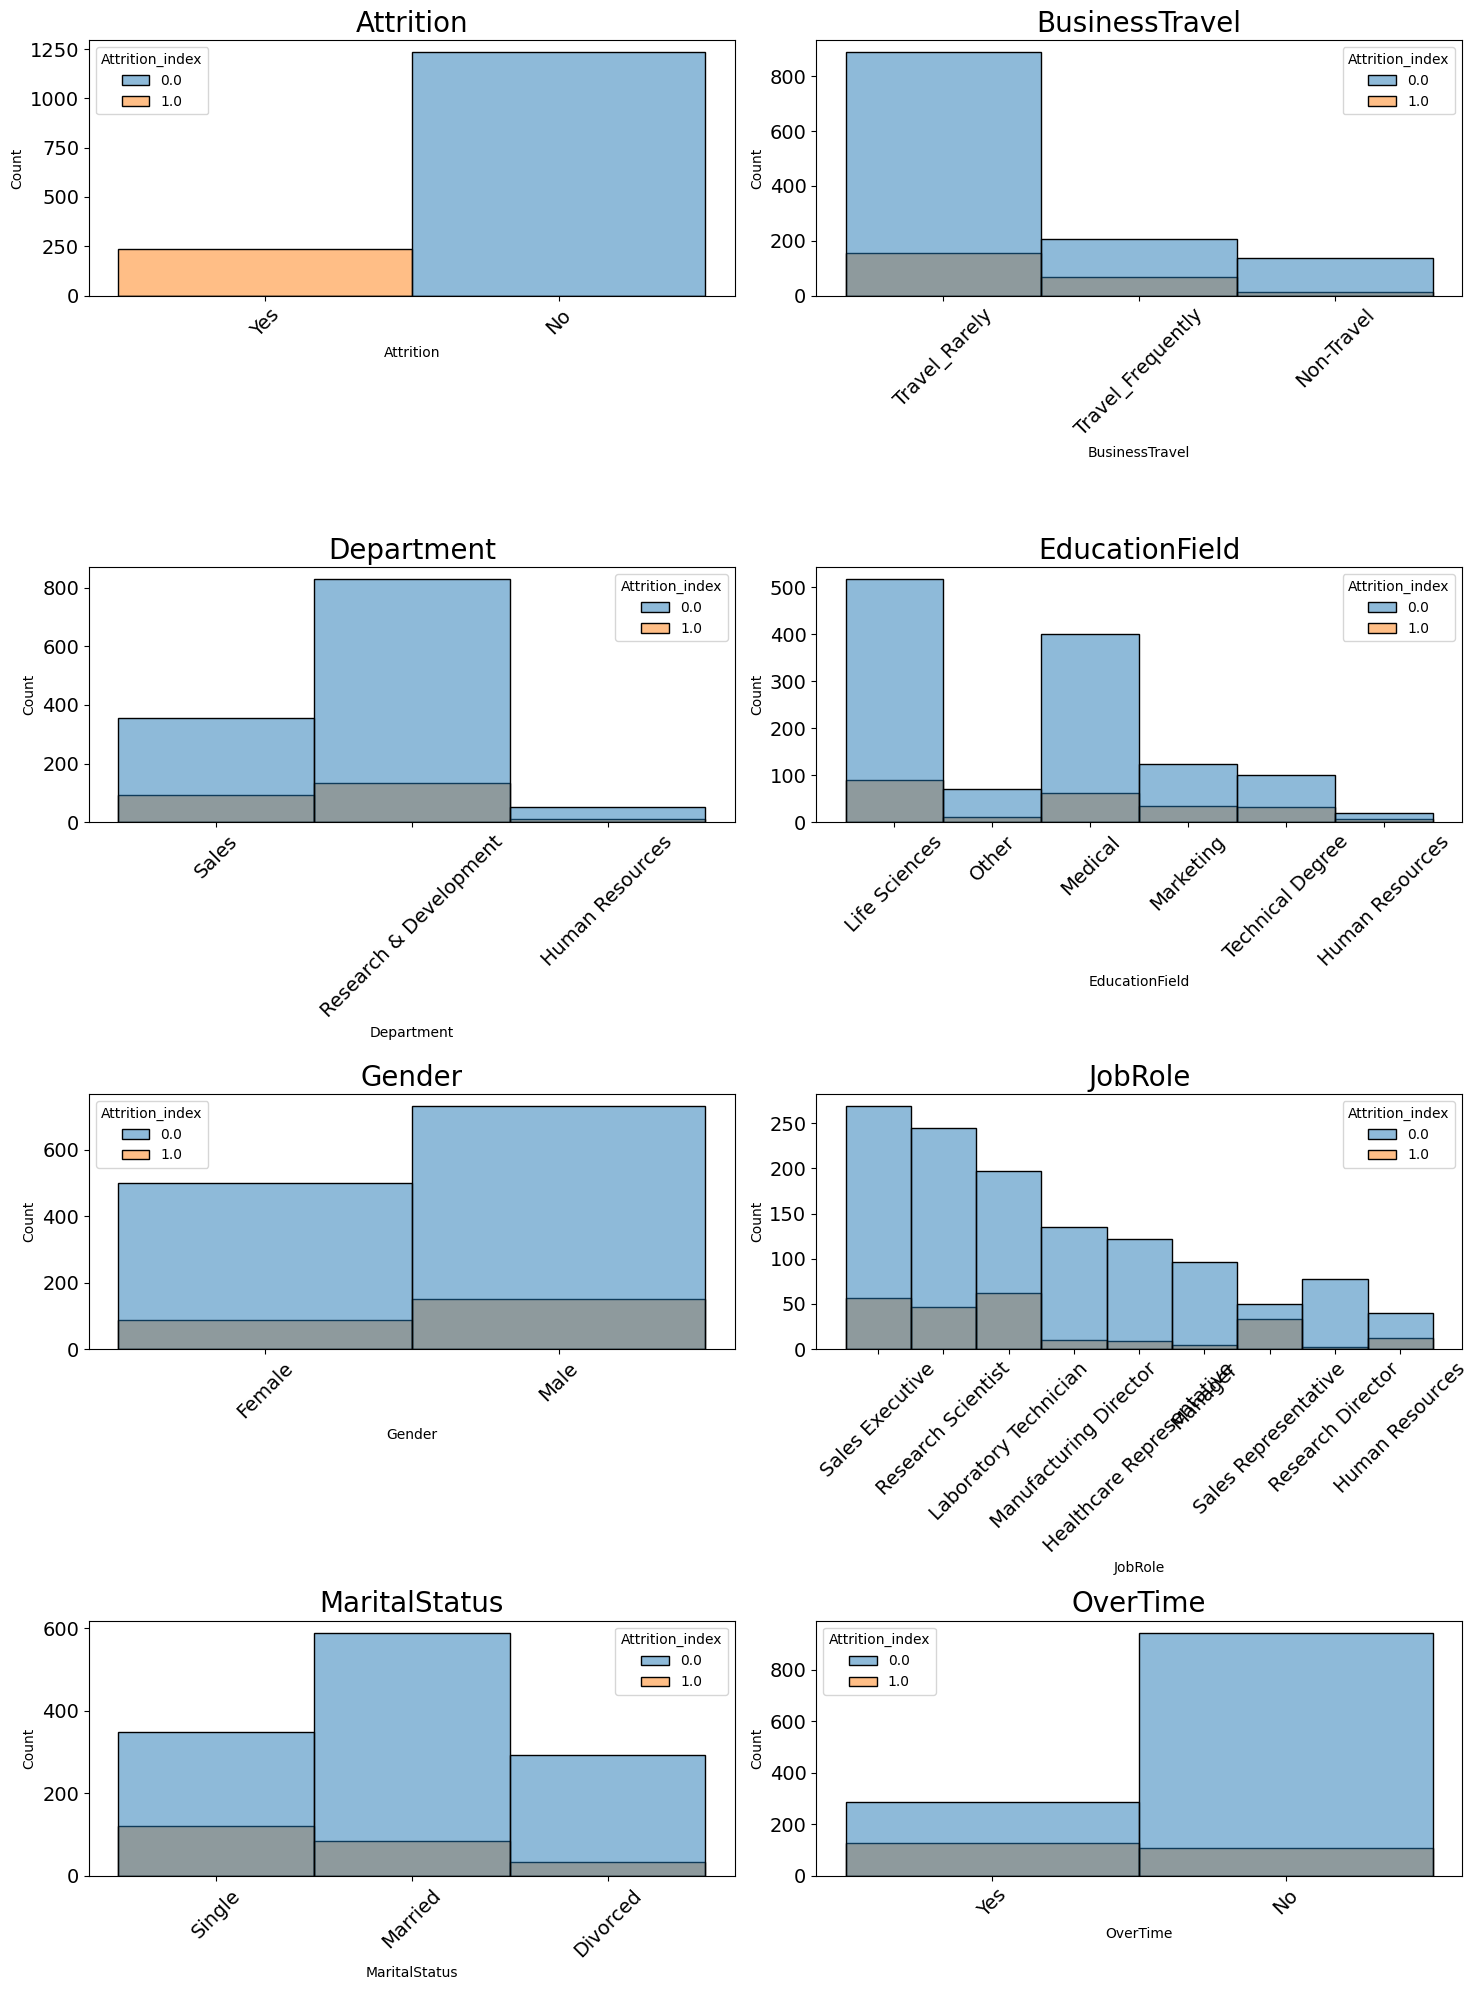

In [24]:
# pandas DataFrame으로 변환
df_pandas = df_indexed.select("Attrition_index", *string_cols).toPandas()

# 서브플롯 생성 (5x4 그리드, 크기 조정)
fig, axes = plt.subplots(4,2, figsize=(15, 20))
axes = axes.flatten()

# 각 수치형 변수에 대해 히스토그램 생성
for i, col in enumerate(string_cols):
    sns.histplot(data=df_pandas, x=col, hue='Attrition_index', ax=axes[i])
    axes[i].set_title(f"{col}", fontsize=20)  
    axes[i].tick_params(axis='x', labelrotation=45, labelsize=14)
    axes[i].tick_params(axis='y', labelsize=14)
plt.tight_layout()
plt.show()

## 수치형 데이터 확인

In [25]:
numeric_cols = [
    "Age", "DistanceFromHome", "Education", "EnvironmentSatisfaction",
    "JobInvolvement", "JobLevel", "JobSatisfaction", "MonthlyIncome",
    "NumCompaniesWorked", "PercentSalaryHike", "PerformanceRating",
    "RelationshipSatisfaction", "StockOptionLevel", "TotalWorkingYears",
    "TrainingTimesLastYear", "WorkLifeBalance", "YearsAtCompany",
    "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager"
]

for col in numeric_cols:
    df.groupBy(col).count().show()

+---+-----+
|Age|count|
+---+-----+
| 31|   69|
| 53|   19|
| 34|   77|
| 28|   48|
| 27|   48|
| 26|   39|
| 44|   33|
| 22|   16|
| 47|   24|
| 52|   18|
| 40|   57|
| 20|   11|
| 57|    4|
| 54|   18|
| 48|   19|
| 19|    9|
| 41|   40|
| 43|   32|
| 37|   50|
| 35|   78|
+---+-----+
only showing top 20 rows

+----------------+-----+
|DistanceFromHome|count|
+----------------+-----+
|              28|   23|
|              27|   12|
|              26|   25|
|              12|   20|
|              22|   19|
|               1|  208|
|              13|   19|
|              16|   32|
|               6|   59|
|               3|   84|
|              20|   25|
|               5|   65|
|              19|   22|
|              15|   26|
|               9|   85|
|              17|   20|
|               4|   64|
|               8|   80|
|              23|   27|
|               7|   84|
+----------------+-----+
only showing top 20 rows

+---------+-----+
|Education|count|
+---------+-----+
|     

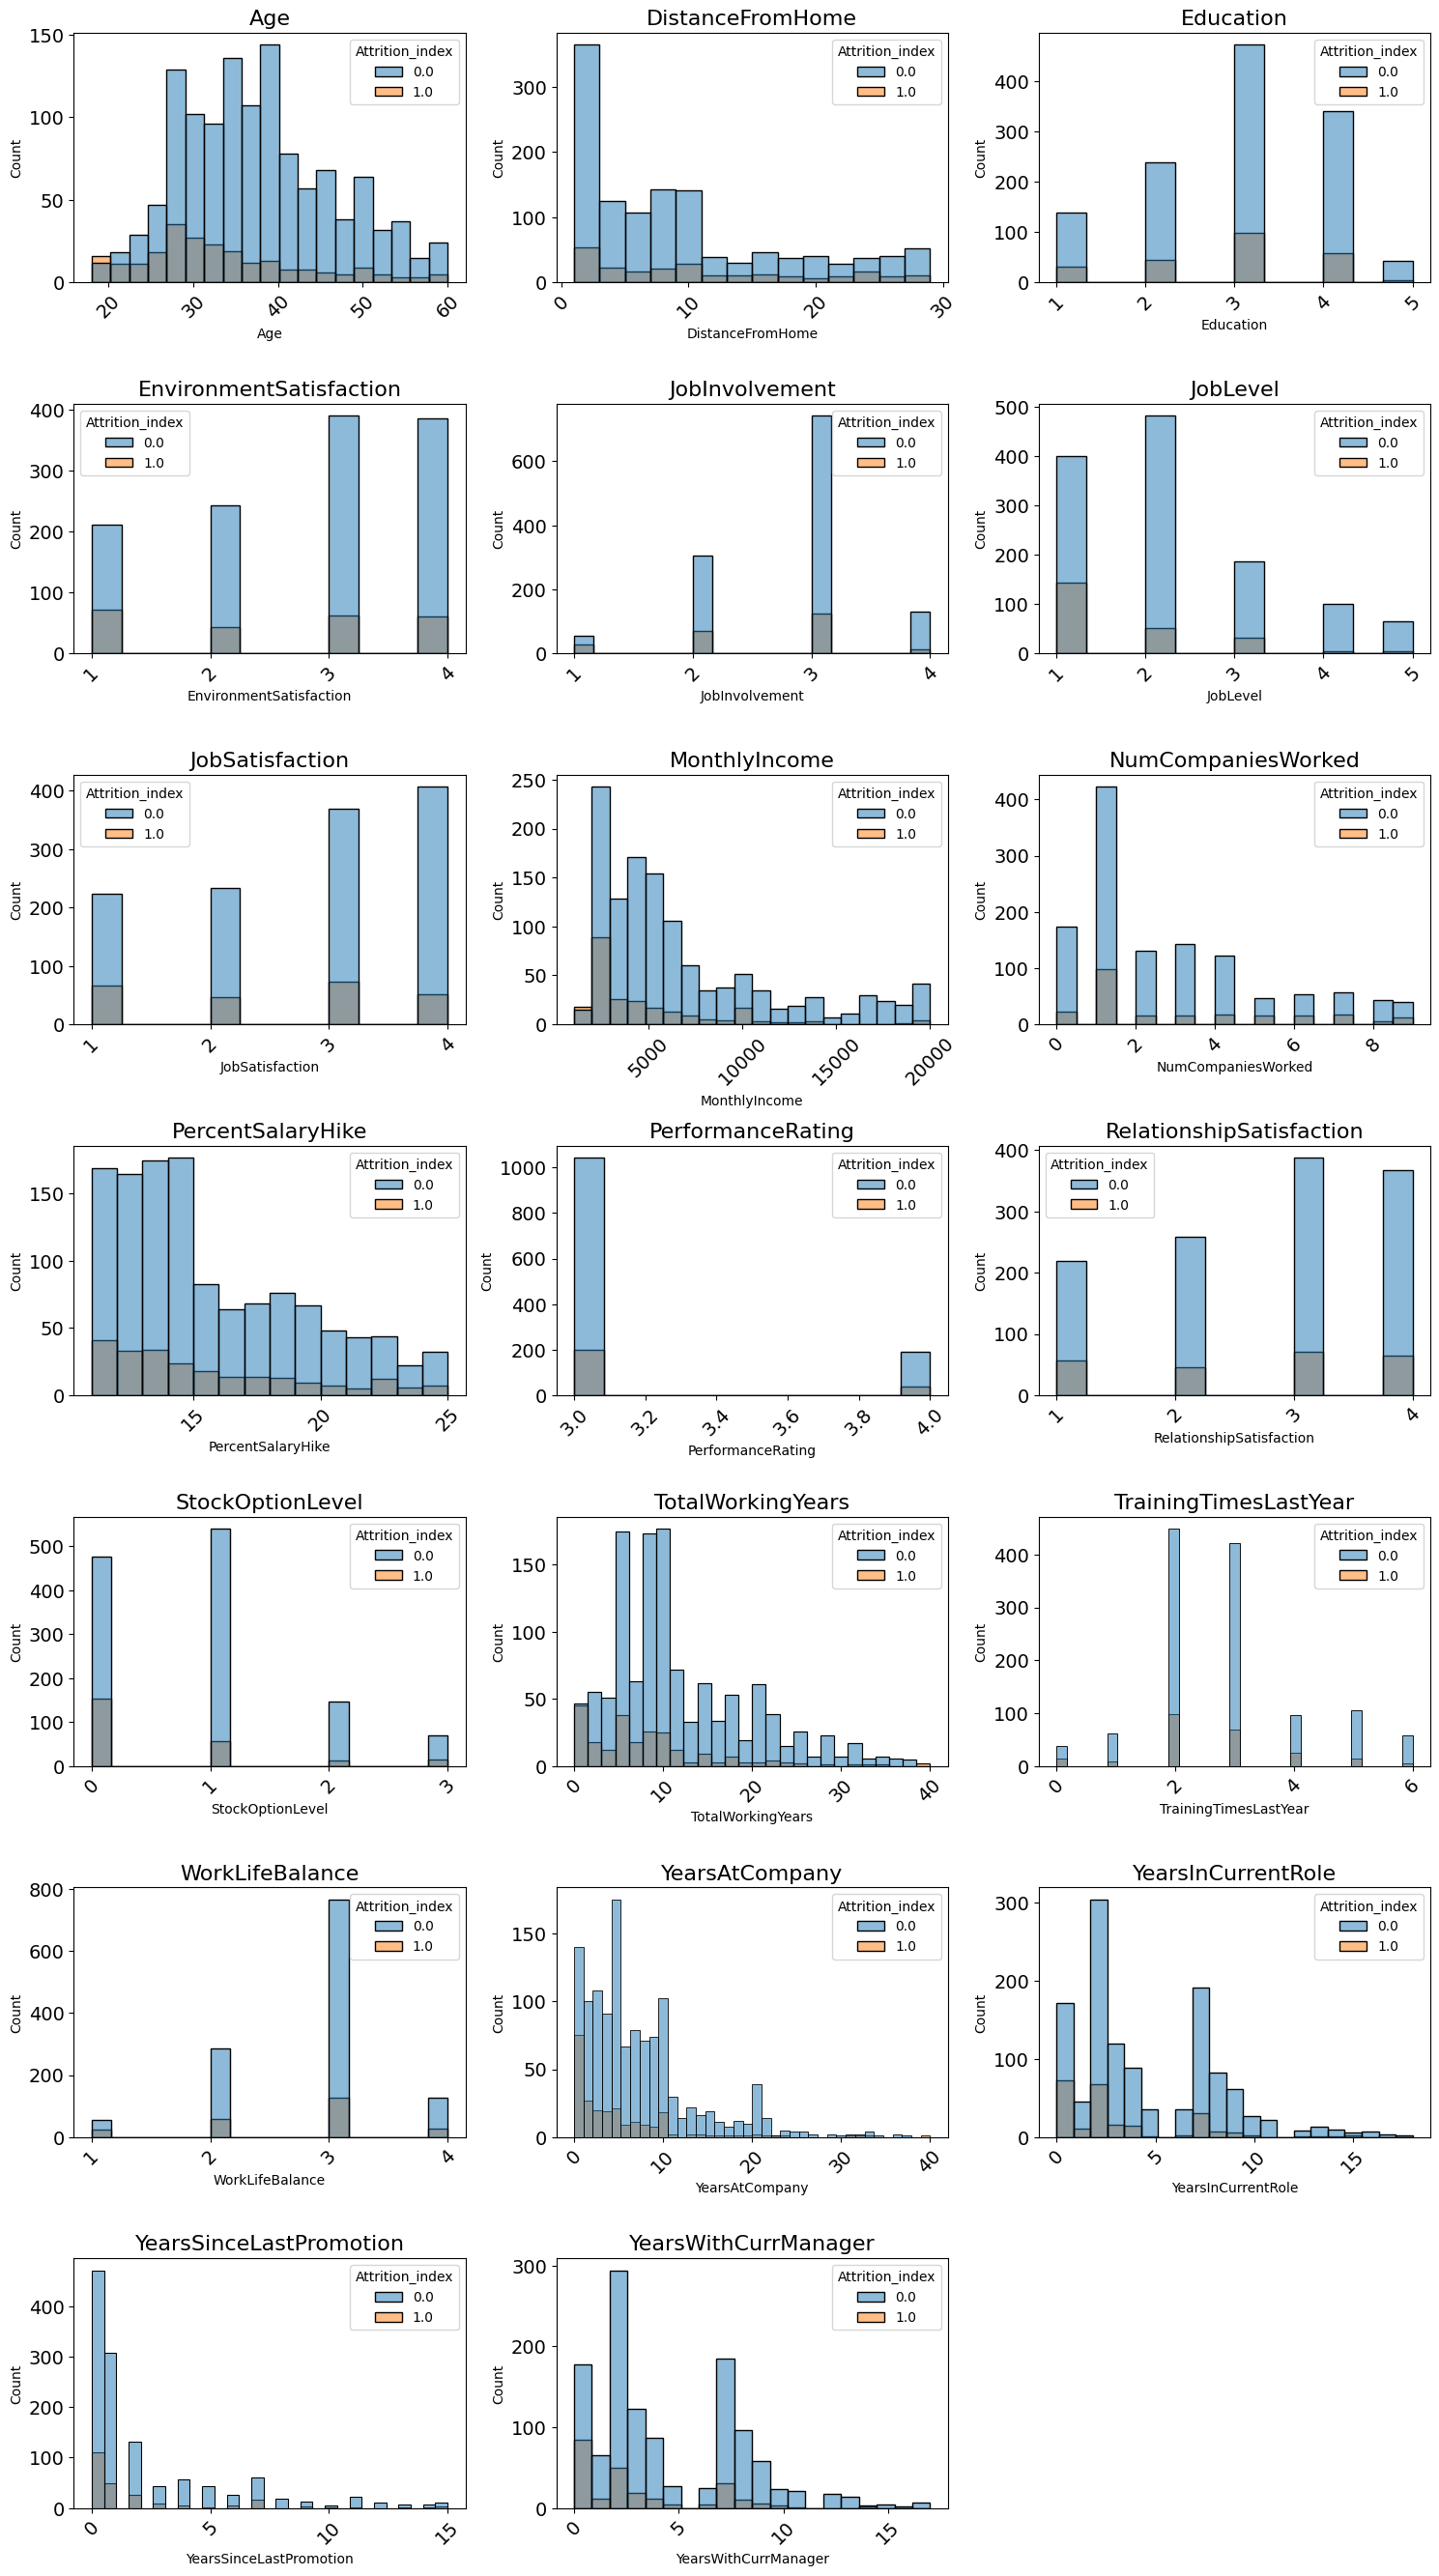

In [26]:
# pandas DataFrame으로 변환
df_pandas = df_indexed.select("Attrition_index", *numeric_cols).toPandas()

# 서브플롯 생성 (5x4 그리드, 크기 조정)
fig, axes = plt.subplots(8,3, figsize=(15, 30))
axes = axes.flatten()

# 각 수치형 변수에 대해 히스토그램 생성
for i, col in enumerate(numeric_cols):
    sns.histplot(data=df_pandas, x=col, hue='Attrition_index', ax=axes[i])
    axes[i].set_title(f"{col}", fontsize=16)
    axes[i].tick_params(axis='x', labelrotation=45, labelsize=14)  
    axes[i].tick_params(axis='y', labelsize=14)

# 남는 서브플롯 제거
for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [27]:
# Pearson 상관계수 계산
df_pandas = df.select(numeric_cols).toPandas()

corr_matrix = df_pandas.corr()
corr_matrix

,Age,DistanceFromHome,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.000000,-0.001686,0.208034,0.010146,0.029820,0.509604,-0.004892,0.497855,0.299635,0.003634,0.001904,0.053535,0.037510,0.680381,-0.019621,-0.021490,0.311309,0.212901,0.216513,0.202089
DistanceFromHome,-0.001686,1.000000,0.021042,-0.016075,0.008783,0.005303,-0.003669,-0.017014,-0.029251,0.040235,0.027110,0.006557,0.044872,0.004628,-0.036942,-0.026556,0.009508,0.018845,0.010029,0.014406
Education,0.208034,0.021042,1.000000,-0.027128,0.042438,0.101589,-0.011296,0.094961,0.126317,-0.011111,-0.024539,-0.009118,0.018422,0.148280,-0.025100,0.009819,0.069114,0.060236,0.054254,0.069065
EnvironmentSatisfaction,0.010146,-0.016075,-0.027128,1.000000,-0.008278,0.001212,-0.006784,-0.006259,0.012594,-0.031701,-0.029548,0.007665,0.003432,-0.002693,-0.019359,0.027627,0.001458,0.018007,0.016194,-0.004999
JobInvolvement,0.029820,0.008783,0.042438,-0.008278,1.000000,-0.012630,-0.021476,-0.015271,0.015012,-0.017205,-0.029071,0.034297,0.021523,-0.005533,-0.015338,-0.014617,-0.021355,0.008717,-0.024184,0.025976
JobLevel,0.509604,0.005303,0.101589,0.001212,-0.012630,1.000000,-0.001944,0.950300,0.142501,-0.034730,-0.021222,0.021642,0.013984,0.782208,-0.018191,0.037818,0.534739,0.389447,0.353885,0.375281
JobSatisfaction,-0.004892,-0.003669,-0.011296,-0.006784,-0.021476,-0.001944,1.000000,-0.007157,-0.055699,0.020002,0.002297,-0.012454,0.010690,-0.020185,-0.005779,-0.019459,-0.003803,-0.002305,-0.018214,-0.027656
MonthlyIncome,0.497855,-0.017014,0.094961,-0.006259,-0.015271,0.950300,-0.007157,1.000000,0.149515,-0.027269,-0.017120,0.025873,0.005408,0.772893,-0.021736,0.030683,0.514285,0.363818,0.344978,0.344079
NumCompaniesWorked,0.299635,-0.029251,0.126317,0.012594,0.015012,0.142501,-0.055699,0.149515,1.000000,-0.010238,-0.014095,0.052733,0.030075,0.237639,-0.066054,-0.008366,-0.118421,-0.090754,-0.036814,-0.110319
PercentSalaryHike,0.003634,0.040235,-0.011111,-0.031701,-0.017205,-0.034730,0.020002,-0.027269,-0.010238,1.000000,0.773550,-0.040490,0.007528,-0.020608,-0.005221,-0.003280,-0.035991,-0.001520,-0.022154,-0.011985


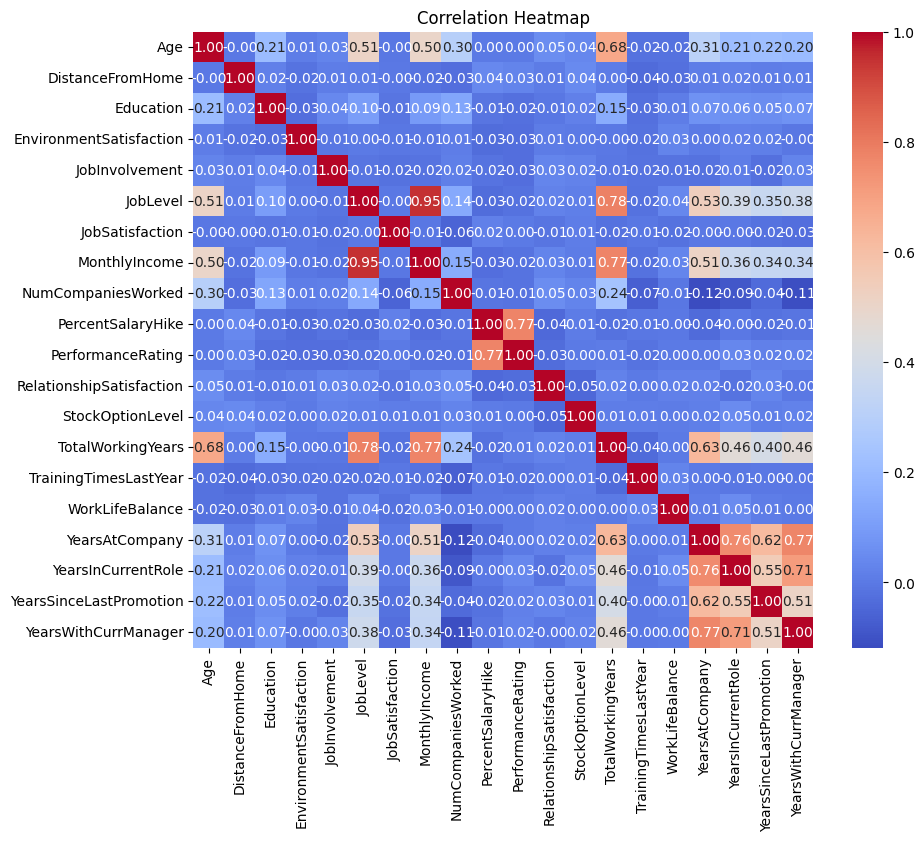

In [28]:
# 상관행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

## 범주형 변수와 Attrition 간의 연관성

# 가설 확인

- 가설 1: MonthlyIncome이 낮으면 Attrition(이직률)이 높을 가능성이 있다.
- 가설 2: JobSatisfaction이 낮으면 Attrition이 높을 가능성이 있다.
- 가설 3: OverTime이 "Yes"인 경우 Attrition이 높을 가능성이 있다.
- 가설 4: 진짜 DistanceFromHome 이 가까우면 Attrition이 낮을까? 
- 가설 5: 나이는? 


## 가설 1 : 이직률에 따른 MonthlyIncome의 평균 비교

In [ ]:
# MonthlyIncome과 Attrition 간의 관계를 시각화
df_pandas = df.toPandas()

sns.boxplot(data=df_pandas, x='Attrition', y='MonthlyIncome', palette='Set2')
plt.title('MonthlyIncome by Attrition', fontsize=15, weight='bold')
plt.xlabel('Attrition', fontsize=12)
plt.ylabel('MonthlyIncome', fontsize=12)

plt.show()

In [ ]:
# 이직 여부에 따라 MonthlyIncome의 평균을 비교
df.groupBy("Attrition").agg(avg("MonthlyIncome").alias("AverageMonthlyIncome")).show()

df_pandas = df.toPandas()

# Boxplot 생성
plt.figure(figsize=(8, 6))
df_pandas.boxplot(by="Attrition", column="MonthlyIncome", grid=False)
plt.title("Monthly Income by Attrition")
plt.suptitle("")
plt.xlabel("Attrition")
plt.ylabel("Monthly Income")
plt.show()

### Monthly Income 과 Attrition 분석 
- 이직한 직원 (Attrition = Yes) 에서 월급의 중앙값은 이직하지 않은 직원보다 낮음
- 분포가 더 좁으며 대부분의 데이터가 하위 구간에 집중
- 낮은 월급을 받는 직원들이 이직할 가능성이 더 높아 보임
- 다른 변수와의 상호작용 분석: 월급 외에도 초과 근무 ("Over Time"), 직무 만족도 ("Job Satisfaction") 과 함께 분석해보기 

## 가설2 : JobSatisfaction이 낮으면 Attrition이 높을 가능성이 있다.

In [ ]:
df.groupBy("Attrition").agg(avg("JobSatisfaction").alias("AverageJobSatisfaction")).show()

df_pandas = df.toPandas()
plt.figure(figsize=(8, 6))
df_pandas.boxplot(by="Attrition", column="JobSatisfaction", grid=False)
plt.title("Job Satisfaction by Attrition")
plt.suptitle("")
plt.xlabel("Attrition")
plt.ylabel("Job Satisfaction")
plt.show()

In [ ]:
#퇴사자 안에서 이직률
print("퇴사자")
df.groupBy("JobSatisfaction").agg((sum(when(col("Attrition") == "Yes", 1).otherwise(0)) / count("*")).alias("AttritionRate")).orderBy("JobSatisfaction").show()

## 가설3 : OverTime이 "Yes"인 경우 Attrition이 높을 가능성이 있다.

In [ ]:
# OverTime 여부별 Attrition 비율
df.groupBy("OverTime", "Attrition").count().show()

df_pandas = df.toPandas()
sns.countplot(x="OverTime", hue="Attrition", data=df_pandas)
plt.title("OverTime and Attrition")
plt.show()

In [ ]:
#퇴사자 안에서 이직률
print("퇴사자")
df.groupBy("OverTime").agg((sum(when(col("Attrition") == "Yes", 1).otherwise(0)) / count("*")).alias("AttritionRate")).orderBy("OverTime").show()

## 가설 4: DistanceFromHome이 가까우면 Attrition이 낮을 가능성이 있다.

In [ ]:
df.groupBy("Attrition").agg(avg("DistanceFromHome").alias("AverageDistanceFromHome")).show()

df_pandas = df.toPandas()
plt.figure(figsize=(8, 6))
df_pandas.boxplot(by="Attrition", column="DistanceFromHome", grid=False)
plt.title("Distance From Home by Attrition")
plt.suptitle("")
plt.xlabel("Attrition")
plt.ylabel("Distance From Home")
plt.show()

# 4. 머신러닝 모델 생성 및 예측

In [5]:
#numeric_cols = ["JobSatisfaction", "MonthlyIncome"]
numeric_cols = [
    "Age", "DistanceFromHome", "Education", "EnvironmentSatisfaction",
    "JobInvolvement", "JobLevel", "JobSatisfaction", "MonthlyIncome",
    "NumCompaniesWorked", "PercentSalaryHike", "PerformanceRating",
    "RelationshipSatisfaction", "StockOptionLevel", "TotalWorkingYears",
    "TrainingTimesLastYear", "WorkLifeBalance", "YearsAtCompany",
    "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager"
]
string_cols = ["Attrition", "BusinessTravel","Department", "EducationField",
    "Gender", "JobRole", "MaritalStatus", "OverTime"]

In [6]:
# StringIndexer를 사용하여 범주형 컬럼을 숫자형으로 변환
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in string_cols]

# OneHotEncoder를 사용하여 범주형 컬럼을 원-핫 인코딩
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") for col in string_cols]

# 문자형(인코딩) + 숫자형 피처를 겨람한 모델 입력 생성
assembler_inputs = [col+"_encoded" for col in string_cols] + numeric_cols
assembler = VectorAssembler(inputCols= assembler_inputs, outputCol="features")

# 파이프라인에 모든 스테이지 추가
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# 데이터 변환
df_transformed = pipeline.fit(df).transform(df)
df_transformed.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- OverTime: string (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- PerformanceRating: integer (nullable = true)
 |-- RelationshipSatisfaction: integer (nullable = true)
 |-- StockOptionLevel: integer (nullable = true)
 |-- TotalWorkingYears: integer (nul

In [7]:
# 훈련 데이터와 테스트 데이터 분리
train_data, test_data = df_transformed.randomSplit([0.7, 0.3], seed=42)

# 로지스틱 회귀 모델
lr = LogisticRegression(featuresCol='features', labelCol='Attrition_index')

# 모델 훈련
model = lr.fit(train_data)

# 예측 수행
predictions = model.transform(test_data)

# 예측 성능 평가
evaluator = BinaryClassificationEvaluator(labelCol='Attrition_index')
auc = evaluator.evaluate(predictions)
print(auc)
# # 1차 결과값 = 0.6718963831867062 - 기본 예측보다는 나은 성능이지만 개선의 여지가 많음 - 아직 최적화디지 않음
# # 2차 결과값 = 0.7806940371456519

24/12/19 18:07:07 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/12/19 18:07:07 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


1.0


In [8]:
predictions.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- OverTime: string (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- PerformanceRating: integer (nullable = true)
 |-- RelationshipSatisfaction: integer (nullable = true)
 |-- StockOptionLevel: integer (nullable = true)
 |-- TotalWorkingYears: integer (nul

In [19]:
predictions.select('Attrition','Attrition_Index', 'prediction', 'probability').show(truncate=False)

+---------+---------------+----------+-------------------------------------------+
|Attrition|Attrition_Index|prediction|probability                                |
+---------+---------------+----------+-------------------------------------------+
|No       |0.0            |0.0       |[0.9999999999897735,1.0226486324427242E-11]|
|Yes      |1.0            |1.0       |[2.214492399204759E-11,0.999999999977855]  |
|No       |0.0            |0.0       |[0.9999999997426665,2.5733348785195176E-10]|
|No       |0.0            |0.0       |[0.9999999919645762,8.035423770813566E-9]  |
|Yes      |1.0            |1.0       |[2.7271715043719885E-9,0.9999999972728285] |
|Yes      |1.0            |1.0       |[1.6562115662442527E-10,0.9999999998343788]|
|Yes      |1.0            |1.0       |[6.709579520052426E-12,0.9999999999932904] |
|No       |0.0            |0.0       |[0.9999999994855688,5.144311643334731E-10] |
|No       |0.0            |0.0       |[0.9999999932038872,6.7961127836468904E-9] |
|Yes

- Attrition, Attrition_Index: 실제 레이블 (No 0, Yes 1)
- prediction: 모델의 예츨 결과 (No 0, Yes 1)
- probability: 예측 확률 - 첫번째 No 일 확률, 두번째 Yes 일 확률

In [ ]:
# 주요 특징 중요도
# features 컬럼을 사용하여 모델 훈련 후, 주요 특징 중요도 계산
coefficients = pd.DataFrame({
    "Feature": assembler.getInputCols(),  # VectorAssembler에서 사용된 입력 컬럼을 가져옵니다.
    "Importance": model.coefficients.toArray()  # 모델의 계수를 가져옵니다.
}).sort_values(by="Importance", ascending=False)
print(coefficients)


In [ ]:
# 인사이트 예시
- 4.485605 JobSatisfaction (직무 만족도)가 모델에서 가장 중요한 특성
- 1.254283 OverTime_encoded (야근 여부)가 두 번째로 중요한 특성
- 0.000156 MonthlyIncome (월급)는 모델에서 상대적으로 중요도가 낮은 특성

## 가설 검증 결과:
```
월급이 낮으면 이직률이 높음
JobSatisfaction이 낮으면 이직률이 높음
OverTime이 많은 경우 이직률이 매우 높음
모델 평가:

로지스틱 회귀 모델 정확도 85%
인사이트 도출:

조직은 OverTime을 줄이고 JobSatisfaction을 개선해야 함.
낮은 MonthlyIncome을 가진 직원에게 추가 혜택을 제공하여 이직을 방지.
```